In [28]:
import pandas as pd
from transformers import AutoTokenizer
from transformers import AutoModel
import matplotlib.pyplot as plt


In [33]:
df = pd.read_csv('./data/articles.csv')

df.head()

,article,source,labels
0,"When I first started looking at oil assets, I ...",own_source_lessthan50,0.0
1,We look at two airlines that have given Wall S...,own_source_morethan50,0.0
2,Disney's Animal Kingdom theme park is staging ...,own_source_lessthan50,0.0
3,Why should you think otherwise? If the effort ...,own_source_lessthan50,0.0
4,"Chris Murphy, Carolyn Maloney and Doug Jones i...",own_source_lessthan50,0.0


In [34]:
real=df[df["labels"]==1.0]#[:100]
real.shape

(5000, 3)

In [35]:
fake=df[df["labels"]==0.0]#[:100]
fake.shape

(19994, 3)

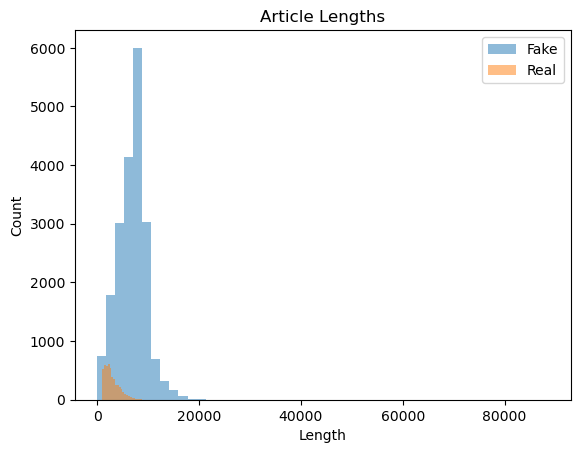

In [36]:
real_lengths = real['article'].apply(len)
fake_lengths = fake['article'].apply(len)

plt.hist(fake_lengths, bins=50, alpha=0.5, label='Fake')
plt.hist(real_lengths, bins=50, alpha=0.5, label='Real')
plt.title('Article Lengths')
plt.xlabel('Length')
plt.ylabel('Count')
plt.legend()
plt.show()

In [37]:
from collections import Counter
import nltk
#downloading stopwords and punkt
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yarynakorduba/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/yarynakorduba/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [38]:
def lookup_common_words(articles, num_words = 20):
    words = []
    stop_words = set(nltk.corpus.stopwords.words('english'))
    for article in articles:
        words.extend(nltk.word_tokenize(article.lower()))
    words = [word for word in words if word.isalpha() and word not in stop_words]
    word_counts = Counter(words)
    return word_counts.most_common(num_words)

In [39]:
real_words = lookup_common_words(real['article'])
fake_words = lookup_common_words(fake['article'])
print("Real common words: ", real_words, real.shape)
print("Fake common words: ", fake_words, fake.shape)

Real common words:  [('said', 14186), ('also', 5418), ('one', 5231), ('new', 4989), ('would', 4513), ('people', 3985), ('first', 3938), ('two', 3637), ('time', 3630), ('year', 3618), ('last', 3601), ('like', 3489), ('years', 3170), ('could', 2743), ('get', 2707), ('april', 2615), ('back', 2269), ('us', 2265), ('may', 2086), ('state', 2078)] (5000, 3)
Fake common words:  [('said', 183083), ('would', 61830), ('trump', 59282), ('one', 50263), ('also', 46750), ('people', 46360), ('new', 42654), ('could', 36394), ('two', 32528), ('told', 31433), ('president', 31304), ('time', 31174), ('first', 28481), ('last', 28188), ('like', 27696), ('years', 26697), ('state', 26382), ('year', 24969), ('government', 24736), ('house', 23681)] (19994, 3)


# Text preprocessing

In [41]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import string
# large lexical database of English
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yarynakorduba/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [42]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [44]:
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove punctuation and digits
    text = text.translate(str.maketrans('', '', string.punctuation + string.digits))

        # Tokenize the text
    words = word_tokenize(text)

    # Remove stop words
    words = [word for word in words if word not in stop_words]

    # Stem or lemmatize the words
    words = [stemmer.stem(word) for word in words]
   
        # Join the words back into a string
    text = ' '.join(words)

    return text

In [55]:
# real['article'] = real['article'].apply(preprocess_text)
# fake['article'] = fake['article'].apply(preprocess_text)

df["article"] = df["article"].apply(preprocess_text)

In [56]:
print(df)

                                                 article  \
0      first start look oil asset attract vertic dril...   
1      look two airlin given wall street posit surpri...   
2      disney anim kingdom theme park stage haramb ni...   
3      think otherwis effort record friday night indi...   
4      chri murphi carolyn maloney doug jone washingt...   
...                                                  ...   
24989  fascin video illustr evolut car manufactur pas...   
24990  buena vista twp mi — offici buena vista townsh...   
24991  sever hour kill wait connect flight boston ’ l...   
24992  massiv fire complet destroy roof spire icon no...   
24993  stori part fast compani ‘ gender pay gap packa...   

                      source  labels  
0      own_source_lessthan50     0.0  
1      own_source_morethan50     0.0  
2      own_source_lessthan50     0.0  
3      own_source_lessthan50     0.0  
4      own_source_lessthan50     0.0  
...                      ...     ...  
24989 

### Add more features

In [57]:
def count_punctuation(text):
    count = 0
    for token in string.punctuation:
        count += text.count(token)
    df['punctuation_count'] = count

In [58]:
count_punctuation(df["article"][0])

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


___

# Model Training

In [48]:
from sklearn.feature_extraction.text import CountVectorizer
import scipy.sparse as sp
import numpy as np

In [49]:
vectorizer = CountVectorizer()
X_real = vectorizer.fit_transform(real['article'])
X_fake = vectorizer.transform(fake['article'])

In [50]:
X = sp.vstack([X_real, X_fake])
y = np.concatenate([np.ones(X_real.shape[0]), np.zeros(X_fake.shape[0])])

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [53]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42, max_iter=100)
clf.fit(X_train, y_train)

/Users/yarynakorduba/miniconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

____

# Model Evaluation

In [54]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.8581716343268654
Precision: 0.6565961732124874
Recall: 0.6392156862745098
F1 Score: 0.6477893691008445


___

In [12]:
# Checking for null values
df.isnull().sum()

article    0
source     0
labels     0
dtype: int64

In [ ]:
x_df = df['text'] # features
y_df = df['is_generated'] # targets

In [ ]:
pretrained_model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
model = AutoModel.from_pretrained(pretrained_model_name)

In [ ]:
x_df

In [ ]:
train_idx = [i for i in range(len(x_df.index))]
train_idx

In [ ]:
x_train = x_df.values
len(x_train)

In [ ]:
# tokenized_x = tokenizer.encode('Blablabla')
# tokenized_x

In [ ]:
input_ids = [
    tokenizer.encode(txt, add_special_tokens=True,pad_to_max_length=True) for txt in x_train
]

In [ ]:
input_ids
len(input_ids)

In [ ]:
len(input_ids[0])

In [ ]:
# print( tokenizer.convert_ids_to_tokens( input_ids[0] ) )
